In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import json

In [46]:
## AUC metric for regression

# taken from https://gist.github.com/smazzanti
# with explanations from:
# https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb


def regression_roc_auc_score(y_true, y_pred, num_rounds=10000):
    """
    Computes Regression-ROC-AUC-score.

    Parameters:
    ----------
    y_true: array-like of shape (n_samples,).
            Binary or continuous target variable.
    y_pred: array-like of shape (n_samples,). Target scores.
    num_rounds: int or string.
                If integer, number of random pairs of observations.
                If string, 'exact', all possible pairs will be evaluated.

    Returns:
    -------
    rroc: float. Regression-ROC-AUC-score.
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    num_pairs = 0
    num_same_sign = 0

    for i, j in _yield_pairs(y_true, num_rounds):
        diff_true = y_true[i] - y_true[j]
        diff_score = y_pred[i] - y_pred[j]
        if diff_true * diff_score > 0:
            num_same_sign += 1
        elif diff_score == 0:
            num_same_sign += .5
        num_pairs += 1

    return num_same_sign / num_pairs


def _yield_pairs(y_true, num_rounds):
    """
    Returns pairs of valid indices.

    Indices must belong to observations having different values.

    Parameters:
    ----------
    y_true: array-like of shape (n_samples,).
            Binary or continuous target variable.
    num_rounds: int or string.
            If integer, number of random pairs of observations to return.
            If string, 'exact', all possible pairs will be returned.

    Yields:
    -------
    i, j: tuple of int of shape (2,). Indices referred to a pair of samples.

    """
    import numpy as np

    if num_rounds == 'exact':
        for i in range(len(y_true)):
            for j in np.where(
                    (y_true != y_true[i]) & (np.arange(len(y_true)) > i))[0]:
                yield i, j
    else:
        for r in range(num_rounds):
            i = np.random.choice(range(len(y_true)))
            j = np.random.choice(np.where(y_true != y_true[i])[0])
            yield i, j


In [86]:
# SimCLR model directory

# SimCLR
# dHCP subset
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-13/13-33-26/STs_dHCP_155_embeddings/'
# dHCP 374
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-09/17-02-23_1/STs_dHCP_embeddings/'
# dHCP, variable foldlabel
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-14//11-26-01/STs_dHCP_374_embeddings/'
# UKB train
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15//14-36-49/STs_dHCP_374_subjects_embeddings/'
# UKB pretrain + dHCP 374 train
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-16/11-54-27/STs_dHCP_374_subjects_embeddings/'

#Parameter to fit regression to
param_to_predict='birth_age'
#param_to_predict='skel_volume'

dir_embeddings = dir+'full_embeddings.csv'
cols = [f'dim{k}' for k in range(1,11)]
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
df_embeddings.columns=['Subject']+cols

# get train and test sets for regression
label_dir = '/neurospin/dico/jlaval/data/dHCP_155/'
test_subjects = pd.read_csv(label_dir+'test_subject.csv', header=None)
test_subjects.columns=['Subject']

train = pd.read_csv(label_dir+'train_subject.csv', header=None)
val = pd.read_csv(label_dir+'validation_subject.csv', header=None)
train_subjects = pd.concat((train, val))
train_subjects.columns=['Subject']

all_subjects = pd.concat((train_subjects, test_subjects))

# stack all info in df
param_dirs = []
param_dir = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/preterm_labels.csv'
param_dirs.append(param_dir)
param_dir = '/neurospin/dico/jlaval/data/dHCP_155/params.csv'
param_dirs.append(param_dir)

# df
df = df_embeddings.copy()
for param_dir in param_dirs:
    param = pd.read_csv(param_dir)
    param_subset = param.loc[param['Subject'].isin(all_subjects['Subject'])]

    #reorder subjects by merging with embeddings
    df = pd.merge(df, param_subset)

#sort by ascending age
df = df.sort_values(by=param_to_predict, axis=0)

In [87]:
# normalize data in df

X = df[cols].to_numpy()
y = df[param_to_predict].to_numpy()

# center and reduce X and y
for k in range(X.shape[1]):
    X[:, k] -= np.mean(X[:, k])
    X[:, k] = X[:, k] / np.max(np.abs(X[:, k]))

y = y - np.mean(y)
y = y / np.max(np.abs(y))

df[cols]=X
df[param_to_predict]=y

[-0.34070899  0.40279285 -0.21064727  0.22759279 -0.20674807  0.04591949
  0.08589565  0.00207786  0.05819524 -0.01827313]


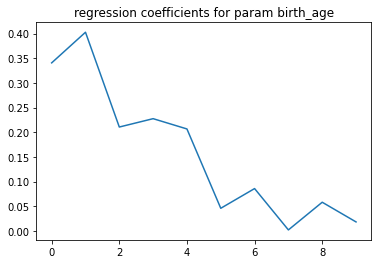

In [88]:
# fit regression on normalized train data

df_train = df.loc[df['Subject'].isin(train_subjects['Subject'])]
X = df_train[cols].to_numpy()
y = df_train[param_to_predict].to_numpy()

reg = LinearRegression().fit(X, y)

print(reg.coef_)
plt.plot(np.abs(reg.coef_))
plt.title(f'regression coefficients for param {param_to_predict}')
plt.show()

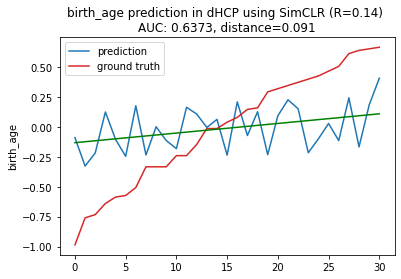

In [89]:
# plot regression on test set and compare to ground truth

# get test normalized data
df_test = df.loc[df['Subject'].isin(test_subjects['Subject'])]
X = df_test[cols].to_numpy()
y = df_test[param_to_predict].to_numpy()

# predict values
pred = reg.predict(X)
# compute AUC
AUC = regression_roc_auc_score(y, pred, num_rounds=10000)
L2_norm = np.linalg.norm((pred,y)) / len(y)
# plot prediction and trend compared to real distribution
x = range(len(y))
z = np.polyfit(x,pred,1)
p = np.poly1d(z)
plt.plot(pred, color='tab:blue', label='prediction')
plt.plot(y, color='tab:red', label='ground truth')
plt.plot(x, p(x), color='green')
plt.ylabel(param_to_predict)
plt.legend()
plt.title(f'{param_to_predict} prediction in dHCP using SimCLR (R={reg.score(X, y):.2f}) \nAUC: {AUC}, distance={L2_norm:.3f}')
plt.show()

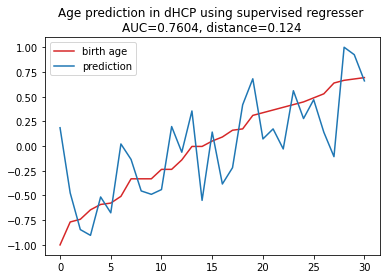

In [9]:
# compare to age profile predicted by supervised regression
supervised_dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-13/13-42-14/STs_dHCP_155_supervised_results/'
pred_dir = supervised_dir+'test_predictions.csv'
with open(supervised_dir+'aucs.json') as f:
    aucs = json.load(f)
    AUC = aucs['test_auc']
df_pred = pd.read_csv(pred_dir, sep=',')
df_pred.sort_values(by='test y', axis=0, inplace=True)
df_pred.reset_index(inplace=True)
# normalize y
y_norm = df_pred[['test pred', 'test y']]
y_norm = y_norm - np.mean(y_norm)
y_norm = y_norm / np.max(np.abs(y_norm))
df_pred[['test pred', 'test y']] = y_norm
L2_norm = np.linalg.norm((df_pred['test pred'],df_pred['test y'])) / len(y)
plt.plot(df_pred['test y'], color='tab:red', label='birth age')
plt.plot(df_pred['test pred'], color='tab:blue', label='prediction')
plt.title(f'Age prediction in dHCP using supervised regresser \nAUC={AUC}, distance={L2_norm:.3f}')
plt.legend()
plt.show()

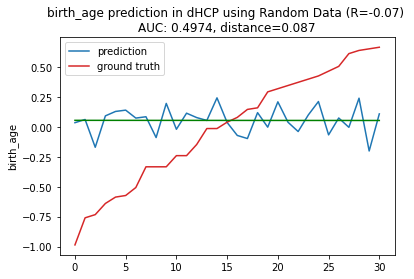

In [55]:
# generate data
X = np.random.rand(155,10)

X_train = X[:-31]
y = df_train[param_to_predict].to_numpy()
reg = LinearRegression().fit(X_train, y)

# predict values
X_test = X[-31:]
y = df_test[param_to_predict].to_numpy()
pred = reg.predict(X_test)
# compute AUC
AUC = regression_roc_auc_score(y, pred, num_rounds=10000)
L2_norm = np.linalg.norm((pred, y)) / len(y)

# plot prediction and trend compared to real distribution
x = range(len(y))
z = np.polyfit(x,pred,1)
p = np.poly1d(z)
plt.plot(pred, color='tab:blue', label='prediction')
plt.plot(y, color='tab:red', label='ground truth')
plt.plot(x, p(x), color='green')
plt.ylabel(param_to_predict)
plt.legend()
plt.title(f'{param_to_predict} prediction in dHCP using Random Data (R={reg.score(X_test, y):.2f}) \nAUC: {AUC}, distance={L2_norm:.3f}')
plt.show()

In [11]:
AUC_list = []

for n in range(500):
    # generate data
    X = np.random.rand(155,10)

    X_train = X[:-31]
    y = df_train[param_to_predict].to_numpy()
    reg = LinearRegression().fit(X_train, y)

    # predict values
    X_test = X[-31:]
    y = df_test[param_to_predict].to_numpy()
    pred = reg.predict(X_test)
    # compute AUC
    AUC = regression_roc_auc_score(y, pred, num_rounds=10000)
    AUC_list.append(AUC)

NameError: name 'AUC_list' is not defined

(array([  2.,   7.,  35.,  63., 129., 145., 116.,  63.,  28.,  12.]),
 array([0.2768 , 0.31747, 0.35814, 0.39881, 0.43948, 0.48015, 0.52082,
        0.56149, 0.60216, 0.64283, 0.6835 ]),
 <BarContainer object of 10 artists>)

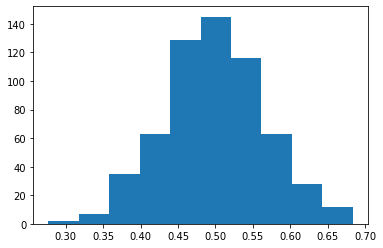

In [ ]:
plt.hist(AUC_list)

In [ ]:
# shuffle data instead of generating random data

## Correlation between prediction and an external parameter

In [12]:
df_train = df.loc[df['Subject'].isin(train_subjects['Subject'])]
X = df_train[cols].to_numpy()
y = df_train[param_to_predict].to_numpy()

reg = LinearRegression().fit(X, y)

df_test = df.loc[df['Subject'].isin(test_subjects['Subject'])]
X = df_test[cols].to_numpy()
y = df_test[param_to_predict].to_numpy()

# predict values
pred = reg.predict(X)
# compute AUC
AUC = regression_roc_auc_score(y, pred, num_rounds=10000)

print(AUC)

0.7012


In [26]:
# load parameter value

# implement a function which takes a parameter and makes the correlation plots

## example to get scan age info
# get the session ids + names of R3
dir_sessions = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_sessions) as f:
    dict_subjects = json.load(f)
sessions = [value['session_id'] for _, value in dict_subjects.items()]
subjects_R3 = list(dict_subjects.keys())

# get the scan age info from info_dHCP
dir_info_dHCP = '/home/jl274628/Documents/info_dHCP.tsv'
info_dHCP = pd.read_csv(dir_info_dHCP, usecols=['participant_id', 'scan_age', 'session_id'], sep='\t')
# filter over subjects
info_dHCP.drop(info_dHCP[~(info_dHCP['participant_id'].isin(subjects_R3))].index, inplace = True)
#info_dHCP.drop(info_dHCP[(info_dHCP['scan_number']!=1)].index, inplace = True) # not always scan 1
# filter over sessions
info_dHCP.drop(info_dHCP[~(info_dHCP['session_id'].isin(sessions))].index, inplace = True)
info_dHCP.reset_index(drop=True, inplace=True)
info_dHCP = info_dHCP[['participant_id', 'scan_age']]
info_dHCP.columns=['Subject', 'scan_age']

In [32]:
param = df_reorder['scan_age'].to_numpy()
#normalize param
param = param - np.mean(param)
param = param / np.max(param)
param

array([ 0.54296178,  0.20818856, -0.24884966,  0.37703071,  1.        ,
       -0.74664288,  0.33336464,  0.08592356, -0.24884966,  0.08592356,
        0.58371678, -0.28960466,  0.25185463, -0.37402573,  0.00150249,
        0.91557893,  0.29260963, -0.37402573, -0.41478073, -0.83106395,
        0.45854071, -0.78739788, -0.70588788, -0.49629073, -0.5399568 ,
       -0.41478073,  0.33336464,  0.49929571,  0.12667856,  0.16743356,
        0.20818856])

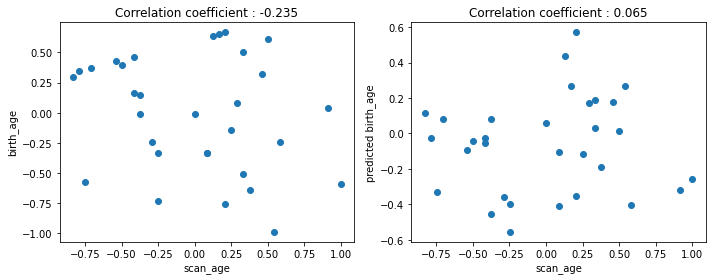

In [44]:
df_reorder = pd.merge(df_test, info_dHCP)

param = df_reorder['scan_age'].to_numpy()
#normalize param
param = param - np.mean(param)
param = param / np.max(np.abs(param))

fig,axs = plt.subplots(ncols=2, figsize=(10,4))
axs[0].scatter(param, y)
axs[0].set_xlabel('scan_age')
axs[0].set_ylabel('birth_age')
axs[0].set_title(f'Correlation coefficient : {np.corrcoef(param, y)[1,0]:.3f}')
axs[1].scatter(param, pred)
axs[1].set_title(f'Correlation coefficient : {np.corrcoef(param, pred)[1,0]:.3f}')
axs[1].set_xlabel('scan_age')
axs[1].set_ylabel('predicted birth_age')

plt.tight_layout()
plt.show()